<a href="https://colab.research.google.com/github/larinsi/DS0P/blob/main/Machine_learning_Middle_level_Neural_networks/06_Semantic_segmentation_Pt1/%D0%9A%D0%BE%D0%BD%D0%B2%D0%B5%D1%80%D1%82%D0%B0%D1%86%D0%B8%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%BD%D0%BE%D0%B9_%D1%81%D0%B5%D1%82%D0%B8_%D0%B2_%D0%BF%D0%BE%D0%BB%D0%BD%D0%BE%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%83%D1%8E.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Конвертация классификационной сети в полносвёрточную (FCN)
В этом уроке мы будем решать задачу локализации с помощью полносвёрточной нейронной сети (FCN). Многие этапы будут такими же, как и в практическом уроке про скользящее окно (всё, что касается построения и обучения классификатора).

Однако, здесь мы не будем применять классификатор в режиме скользящего окна. В этому уроке мы сконвертируем обученный классификатор в FCN и применим полученную FCN для решения задачи локализации (построение тепловых карт) за один проход.

### Загрузка необходимых библиотек
Здесь мы загружаем различные библиотеки, включая TensoFlow.


In [ ]:
import random
import imageio
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
#tf.enable_eager_execution()
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.7.0


# Подготовка датасета

### Загрузка оригинального датасета MNIST
Загружаем датасет MNIST (train и test) и приводим данные к удобному формату:
* Размер: (N, 28, 28, 1), где N - количество образцов в подвыборке
* Значения интесивности: float32 в диапазоне [0, 1]

In [ ]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32) / 255.

11501568/11490434 [==============================] - 0s 0us/step


### Визуализация нескольких образцов из MNIST
Визуализируем несколько образцов из оригинального датасета MNIST

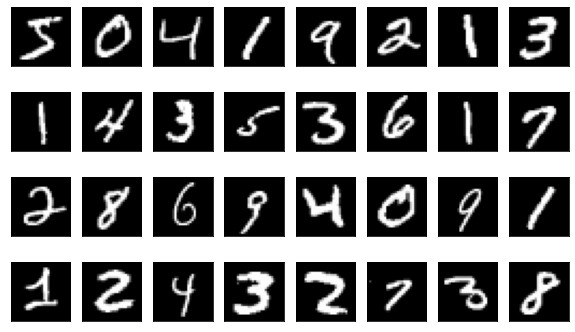

In [ ]:
def plot_some_samples(some_samples):
    fig = plt.figure(figsize=(10, 6))
    for j in range(some_samples.shape[0]):
        ax = fig.add_subplot(4, 8, j+1)
        ax.imshow(some_samples[j,:,:,0], cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_some_samples(train_x[:32, ...])

### Аугментация: добавление образцов класса "фон"
Так же, как и раньше, нам понадобятся дополнительные образцы из класса "фон". Сгенерируем их тем же способом, что и раньше.

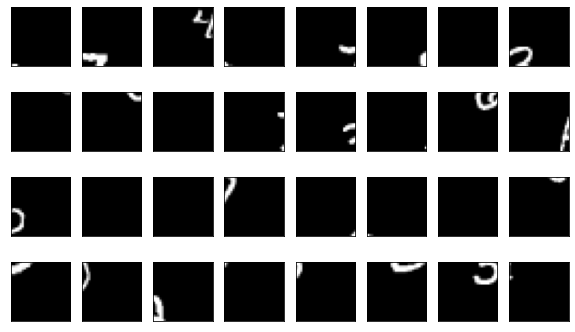

In [ ]:
bg_samples = 100000 # Количество обучающих образцов из класса "фон"

bg_train_x = np.zeros((bg_samples, 28, 28, 1), dtype=np.float32)
bg_train_y = np.ones((bg_samples,), dtype=np.int32)*10 

src_idxs = random.choices(range(train_x.shape[0]), k=bg_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(bg_samples):
    dh = random.randint(sh//4, 3*sh//4) * random.choice([-1, 1])
    dw = random.randint(sw//4, 3*sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    bg_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]

plot_some_samples(bg_train_x[:32, ...])

### Аугментация: добавление образцов исходных классов цифр
Так же, как и раньше, нам понадобятся дополнительные образцы цифр с небольшими смещениями. Сгенерируем их тем же способом, что и раньше.

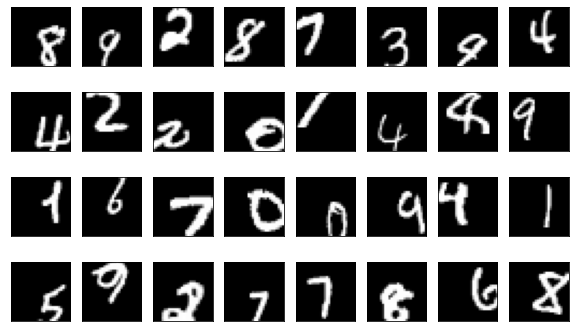

In [ ]:
sh_samples = 50000 # Количество дополнительно сгенерированных образов для цифр (со смещениями)

sh_train_x = np.zeros((sh_samples, 28, 28, 1), dtype=np.float32)
sh_train_y = np.zeros((sh_samples,), dtype=np.int32)

src_idxs = random.sample(range(train_x.shape[0]), sh_samples)

sh = train_x.shape[1]
sw = train_x.shape[2]
for i in range(sh_samples):
    dh = random.randint(0, sh//4) * random.choice([-1, 1])
    dw = random.randint(0, sw//4) * random.choice([-1, 1])

    sample = train_x[src_idxs[i], ...]

    sh_train_x[i, max(-dh,0):min(sh-dh,sh), max(-dw,0):min(sw-dw, sw), :] = \
        sample[max( dh,0):min(sh+dh,sh), max( dw,0):min(sw+dw, sw), :]
    sh_train_y[i] = train_y[src_idxs[i]]

plot_some_samples(sh_train_x[:32, ...])

### Объединение исходного датасета MNSIT и двух новых сгенерированных
Получаем финальные train и test датасеты, содержащие исходные и новые сгенерированные данные (конкатенируем всё по нулевому измерению)

In [ ]:
train_x = np.concatenate((train_x, bg_train_x, sh_train_x), axis=0)
train_y = np.concatenate((train_y, bg_train_y, sh_train_y), axis=0)

# Обучение классификатора

Для начала нам необходимо обучить обычный классификатор для распознавания цифр, но на нашем новом аугментированном датасете с классом "фон". Далее мы будем сконвертируем этот классификатор в FCN и применим для задачи слабой локализации.

### Параметры обучения

In [ ]:
NUM_CLASSES = 11
NUM_EPOCHS = 3
BATCH_SIZE = 64

### Классификационная модель
Это наш классификатор на основе CNN. На выходе 11 классов.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
])

### Подготовка модели к обучению

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

### Обучение модели

In [ ]:
model.fit(train_x, train_y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/3
3282/3282 [==============================] - 69s 18ms/step - loss: 0.0994 - accuracy: 0.9695
Epoch 2/3
3282/3282 [==============================] - 59s 18ms/step - loss: 0.0381 - accuracy: 0.9879
Epoch 3/3
3282/3282 [==============================] - 57s 17ms/step - loss: 0.0264 - accuracy: 0.9912


### Оценка качества классификационной модели

In [ ]:
model.evaluate(test_x, test_y)

313/313 [==============================] - 3s 7ms/step - loss: 0.0231 - accuracy: 0.9925


[0.02306041307747364, 0.9925000071525574]

# Слабая локализация с помощью FCN
Теперь у нас есть обученный классификатор. Нам лишь остаётся конвертировать его в FCN  и применить эту FCN для задачи локализации -- получить тепловые карты в один проход.

Конвертация в FCN будет происходить в два этапа: сначала мы создадим целевую архитектуру FCN со случайными параметрами (весами), а затем скопируем соответствующие параметры (веса) из классификатора в FCN.

### Получение входного изображения для локализации

Можно сгенерировать случайное изображение с несколькими случайными цифрами из тестового множества

А можно загрузить готовое изображение digits.png

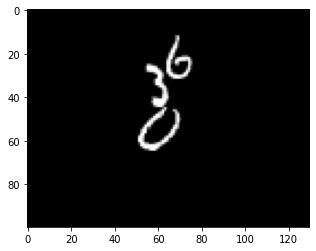

In [ ]:
if True: # Сгенерировать случайное изображение
    
    img = np.zeros((100, 130, 1), dtype=np.float32)
    def add_digit(img, digit):
        ofs = (random.randint(0, img.shape[0]-digit.shape[0]),
               random.randint(0, img.shape[1]-digit.shape[1]))
        img[ofs[0]:ofs[0]+digit.shape[0], ofs[1]:ofs[1]+digit.shape[1], :] += digit
        img = np.clip(img, 0.0, 1.0)
        return img
    for _ in range(3):
        digit = test_x[random.randint(0, test_x.shape[0])]
        img = add_digit(img, digit)
    
else: # Загрузить готовое изображение 'digits.png'
    
    INPUT_IMAGE_FPTAH = 'digits.png'
    img = imageio.imread(INPUT_IMAGE_FPTAH, pilmode="RGB")
    img = img.astype(np.float32)/255.
    img = np.mean(img, axis=2, keepdims=True)
    
# Превращение входной картинки в RGB 
# (для визуалзации и последующего смешивания с цветной тепловой картой)
img_clr = np.tile(img, (1, 1, 3))
_=plt.imshow(img_clr)

### Создание FCN модели
Создадим модель FCN. Она очень похожа на классификационную модель, но все полносвязные слои здесь заменены на свёрточные. Все кроме первого Dense слоя заменены на свёртки 1x1 (в нашем случае это лишь последний слой, так как их всего два). А первый Dense слой заменён на свёртку 7x7

**[ЗАДАНИЕ 1]** Вопрос: почему первый Dense слой мы заменили на свёртку 7x7, а не 1x1?

Далее мы будем копировать в эту FCN модель параметры (веса) из обученной классификационной модели.
Для того, чтобы в такой keras модели инициализировались слои (куда мы будем что-то копировать), нужно выполнить метод `build(shape)`. `shape` - желаемый размер входного тензора в нейросеть. `None` означает, что батч-сайз и пространственные размеры могут быть произвольными (ведь слои в нашей FCN никак не зависят от размера входа), а вот количество каналов (1) важно, так как оно участвует в определении размеров параметров первого свёрточного слоя в модели.

In [ ]:
model_fcn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), (2, 2), padding='same'),
    tf.keras.layers.Conv2D(256, (7, 7), activation='relu', padding='valid'),
    tf.keras.layers.Conv2D(NUM_CLASSES, (1, 1), activation='softmax', padding='valid'),
])

model_fcn.build((None, None, None, 1))

### Список слоёв исходной модели
Для того, чтобы скопировать параметры классификационной сети в FCN сеть, нужно посмотреть, где эти параметры находятся (как до них добраться). Для этого распечатаем список слоёв исходной и новой модели.

In [ ]:
for idx, layer in enumerate(model.layers):
    print('{} ==> {}'.format(idx, layer))

0 ==> <keras.layers.convolutional.Conv2D object at 0x7f2ec54558d0>
1 ==> <keras.layers.convolutional.Conv2D object at 0x7f2ec5608c10>
2 ==> <keras.layers.pooling.MaxPooling2D object at 0x7f2ec590cdd0>
3 ==> <keras.layers.convolutional.Conv2D object at 0x7f2ec45822d0>
4 ==> <keras.layers.pooling.MaxPooling2D object at 0x7f2ec4582710>
5 ==> <keras.layers.core.flatten.Flatten object at 0x7f2ec4582bd0>
6 ==> <keras.layers.core.dense.Dense object at 0x7f2ec4582c50>
7 ==> <keras.layers.core.dense.Dense object at 0x7f2ec457e0d0>


### Список слоёв новой FCN модели

In [ ]:
for idx, layer in enumerate(model_fcn.layers):
    print('{} ==> {}'.format(idx, layer))

0 ==> <keras.layers.convolutional.Conv2D object at 0x7f2ec5665590>
1 ==> <keras.layers.convolutional.Conv2D object at 0x7f2ec56655d0>
2 ==> <keras.layers.pooling.MaxPooling2D object at 0x7f2ec5665f50>
3 ==> <keras.layers.convolutional.Conv2D object at 0x7f2ec57b8cd0>
4 ==> <keras.layers.pooling.MaxPooling2D object at 0x7f2ec5717290>
5 ==> <keras.layers.convolutional.Conv2D object at 0x7f2ec5717410>
6 ==> <keras.layers.convolutional.Conv2D object at 0x7f2ec57179d0>


### Копирование параметров из исходной модели
Нас интересуют только полносвязные и свёрточные слои, так как только у них есть обучаемые параметры.
У каждого такого слоя есть тензоры `kernel` и `bias`, которые означают веса и биас соответственно. В случае полносвязного слоя веса это матрица, а в случае свёрточного - четырёхмерный тензор с ядрами свёрток.

Первые два свёрточных слоя копируем как есть, без изменений.

А вот для двух полносвязных слоёв нужно применить reshape, чтобы скопировать веса из них в новые свёрточные слои.

**[ЗАДАНИЕ 2]** Вопрос: почему вызовы `reshape` имеют такие параметры `(7, 7, 64, 256)` и `(1, 1, 256, 11)` ?

In [ ]:
model_fcn.layers[0].kernel = model.layers[0].kernel
model_fcn.layers[0].bias = model.layers[0].bias
model_fcn.layers[1].kernel = model.layers[1].kernel
model_fcn.layers[1].bias = model.layers[1].bias
model_fcn.layers[3].kernel = model.layers[3].kernel
model_fcn.layers[3].bias = model.layers[3].bias
model_fcn.layers[5].kernel = tf.reshape(model.layers[6].kernel, (7, 7, 128, 256))
model_fcn.layers[5].bias = model.layers[6].bias
model_fcn.layers[6].kernel = tf.reshape(model.layers[7].kernel, (1, 1, 256, 11))
model_fcn.layers[6].bias = model.layers[7].bias

### Запуск FCN для входной картинки и получение тепловых карт

Теперь наша FCN модель готова к слабой локализации. На вход можно сразу подавать входное изображение (не забыв приклеить дополнительное измерение для батча `img[None, ...]`)
Предсказание делается в один проход, что должно быть существенно быстрее метода скользящего окна.

**[ЗАДАНИЕ 3]** Реализуйте получение тепловых карт (трёхмерный тензор `heatmaps`) с использованием FCN в одну строчку. Используйте магическую команду `%%time` для измерения времени работы такого подхода. Сравните время работы с временем работы скользящего окна из предыдущего практического урока.

In [ ]:
%%time
heatmaps = # ваш код

SyntaxError: ignored

### Расширение тепловых карт
Теперь нам понадобится сделать расширение тепловых карт до размеров исходной картинки.

Так как мы использовали пулинги, выходные тепловые карты получились в низком разрешении, поэтому сначала надо сделать upscale (resize) до размера исходной картинки, но с учётом рецептивного поля нейросети.

Далее сделаем финальный паддинг до размера исходной картинки.

In [ ]:
from skimage.transform import resize

rec_field = (28, 28) # рецептивное поле FCN модели

# Сначала масштабируем тепловые карты
heatmaps = resize(heatmaps, (
        img.shape[0]-rec_field[0]+1, 
        img.shape[1]-rec_field[1]+1), 
    order=3, mode='reflect', anti_aliasing=True)

# Потом делаем паддинг
diff = (img.shape[0]-heatmaps.shape[0],
        img.shape[1]-heatmaps.shape[1],)
heatmaps = np.pad(heatmaps, (
    (diff[0]//2,diff[0]-diff[0]//2),
    (diff[1]//2,diff[1]-diff[1]//2),
    (0, 0)
), 'constant')

### Визуализация тепловых карт для разных классов
Визуализируем тепловые карты, соответствующие разным классам, наложенные на исходное изображение

In [ ]:
for clss in range(11):
    heatmap = heatmaps[..., clss]
    heatmap_clr = plt.get_cmap('jet')(heatmap)[..., :3]
    print('Heatmap for class:', clss)
    plt.imshow(img_clr*0.5 + heatmap_clr*0.5)    
    plt.show()